In [9]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import os
import sys

sns.set_style("white")
sns.set_palette("colorblind")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate
from Speedup import get_percent_speedup
from Plotter import format_plot_2ys

OURSYSTEM = "SB"
BASELINE = "Baseline"
RANDOM = "Random"
BASELINE_COLOR ="#009e73"
SB_COLOR = "#cc79a7"


In [76]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, num_analyzed, acc, seconds_elapsed=None):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.num_forwards = num_analyzed
        self.acc = acc
        self.seconds_elapsed = seconds_elapsed

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)

def parse_line_v3(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        num_skipped_fp = int(vals[4])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
        
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        num_skipped_fp = int(vals[6])
        line_type = "test_debug"
    else:
        return None
    
    num_analyzed = num_skipped_fp + num_backprop + num_skipped
    
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, num_analyzed, acc)

def parse_line_v4(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        num_skipped_fp = int(vals[4])
        loss = float(vals[5])
        num_forwards = int(vals[6])
        acc = float(vals[7])
        seconds_elapsed = float(vals[8])
        line_type = "train_debug"
        
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        num_skipped_fp = int(vals[6])
        seconds_elapsed = float(vals[7]) 
        line_type = "test_debug"
    else:
        return None
    
    num_analyzed = num_skipped_fp + num_backprop + num_skipped
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, num_analyzed, acc, seconds_elapsed)

def parse_line_v5(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        num_skipped_fp = int(vals[4])
        loss = float(vals[5])
        num_forwards = int(vals[6])
        acc = float(vals[7])
        seconds_elapsed = float(vals[8])
        line_type = "train_debug"
        
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        num_skipped_fp = int(vals[6])
        seconds_elapsed = float(vals[7]) 
        line_type = "test_debug"
    else:
        return None
    
    num_analyzed = num_backprop + num_skipped - num_skipped_fp
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, num_analyzed, acc, seconds_elapsed)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v3
    if version == "v4":
        return parse_line_v4
    if version == "v5":
        return parse_line_v5
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [282]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        if groups[6] == "0.0005":
            self.prob_pow = 3
        else:
            self.prob_pow = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
    @property
    def color(self):
        if self.strategy == "sb-random-alwayson":
            color = "red"
        elif self.strategy == "sb-relative-alwayson":
            color = "pink"
        elif self.strategy == "sb-relative-stale":
            color = "purple"
        elif self.strategy == "nofilter":
            color = "blue"
        else:
            color = "green"
        return color
        
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "lowk":
            label = "{}, {}, {}, lowest_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy == "randomk":
            label = "{}, {}, {}, random_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.pool_size),
                                                      self.lr)
        elif self.strategy in ["kath-baseline", "kath-biased", "kath-reweighted"]:
            label = "{}, {} [{}]".format(self.strategy, self.prob_pow, self.experiment_name)
        elif "sampling" in self.strategy or self.strategy == "deterministic":
            if self.top_k == 0:
                label = "{}, {} [{}]".format(self.strategy, self.prob_pow, self.experiment_name)
            elif self.top_k == 1:
                label = "{}, {} [{}]".format(BASELINE, self.prob_pow, self.experiment_name)
        elif "sb" in self.strategy:
            if self.top_k == 0:
                label = "{}, {} [{}]".format(self.strategy, self.prob_pow, self.experiment_name)
            elif self.top_k == 1:
                label = "{}, {} [{}]".format(BASELINE, self.prob_pow, self.experiment_name)
        elif self.strategy == "nofilter":
            label = "{}, {} [{}]".format(self.strategy,
                                         self.prob_pow,
                                         self.experiment_name,
                                        ) 
        elif self.strategy == "alwayson":
            label = "{}, {}".format(self.strategy,
                                        self.experiment_name)
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        #if self.seed:
        #    label += ", seed-{}".format(self.seed)
        #else:
        #    label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * 1.2})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [231]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         ylog=False,
         annotate_accuracy=False,
         annotate_error=False,
         target_errors=None):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))
        if annotate_error:
            label += ", Err:{}".format(min(ys))

        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)

            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}".format(plot_dir,
                                        xlabel,
                                        ylabel).replace(" ", "-")
        if ylog:
            plt.yscale("log")
        format_plot(xlabel, ylabel)
        
        if target_errors:
            for target_error in target_errors:
                plt.axhline(y=target_error, color='gray', linestyle=':', linewidth=0.2)
        write_file(plot_prefix, show=True)




In [247]:
def make_instantaneous(l):
    lcopy = l[:]
    lcopy.insert(0, 0)        
    pairs = zip(lcopy[::1], lcopy[1::1])
    ilist = [j - i for i, j in pairs]
    return ilist

def smooth(l, constant):
    for i in range(constant):
        l = [(l+r) / 2. for l, r in zip(l[:-1], l[1:])]
    return l
            
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None,
                     strategies=None,
                     batch_sizes=None,
                     target_errors = None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    test_seconds_elapsed_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    test_errors_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if ".lr" in filename or ".prof" in filename or filename == ".DS_Store" or filename == "pickles" or filename == "sha" or ".swp" in filename:
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue
            if strategies and config.strategy not in strategies:
                continue
            if batch_sizes and config.pool_size not in batch_sizes:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_forwards) / 1000000. for l in test_lines]
            train_num_inferences = [(l.num_forwards) / 1000000. for l in train_lines]

            instantaneous_train_num_backprops = make_instantaneous(train_num_backprops)
            instantaneous_train_num_inferences = make_instantaneous(train_num_inferences)

            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            test_errors = [(100-l.acc) / 100. for l in test_lines]
            
            test_seconds_elapsed = [l.seconds_elapsed for l in test_lines]
            
            ratio_backpropped_ys = smooth([x / float(y) \
                                           for x, y in zip(instantaneous_train_num_backprops,
                                                           instantaneous_train_num_inferences)
                                           if y > 0], 10)
            ratio_backpropped_xs = smooth([l.num_backprop / 1000000. \
                                           for l in train_lines \
                                           if (l.num_backprop + l.num_skip) > 0], 10)
            
            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_seconds_elapsed_by_config[config] = test_seconds_elapsed
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            test_errors_by_config[config] = test_errors
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Ratio Backpropped", plot_dir, smoothing, lw=0.8, ymin=0, xmax=xmax)
    #plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, annotate_accuracy=True)
    plot(test_num_backprops_by_config, test_errors_by_config, "Num Images Backpropped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=False, target_errors=target_errors, annotate_error=True)
    plot(test_num_inferences_by_config, test_errors_by_config, "Num Images Forward Propped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, ylog=False, target_errors=target_errors, annotate_error=True)
    plot(test_seconds_elapsed_by_config, test_errors_by_config, "Seconds elapsed", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=False, target_errors=target_errors, annotate_error=True)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)

In [273]:
def plot_pareto(experiment_names,
                experiments_dir,
                plot_dir,
                plot_label,
                lrs=None,
                nets=None,
                trials=None,
                sampling_mins=None,
                strategies=None,
                batch_sizes=None):
    max_x = 0
    max_y = 0
    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if ".lr" in filename or ".prof" in filename or filename == ".DS_Store" or filename == "pickles" or filename == "sha" or ".swp" in filename:
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
    
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue
            if strategies and config.strategy not in strategies:
                continue
            if batch_sizes and config.pool_size not in batch_sizes:
                continue

            test_seconds_elapsed = [l.seconds_elapsed for l in test_lines]
            test_errors = [(100-l.acc) / 100. for l in test_lines]
            if len(test_errors) == 0:
                print("No data for {}".format(filepath))
                continue
            index = test_errors.index(min(test_errors))
            final_error_percentage = min(test_errors) * 100.
            seconds_elapsed = test_seconds_elapsed[index]
            
            if seconds_elapsed > max_x:
                max_x = seconds_elapsed
            if final_error_percentage > max_y:
                max_y = final_error_percentage
                
            plt.scatter(seconds_elapsed, final_error_percentage, color=config.color, label="{} ({}%)".format(config.strategy,
                                                                                                             round(final_error_percentage, 2)))
    format_plot("Wall-clock time", "Final error %")
    plt.xlim(0, max_x + 1000)
    plt.ylim(0, max_y + 1)
    plt.legend()  
    plot_prefix = "{}/pareto-{}".format(plot_dir, plot_label)
    write_file(plot_prefix, show=True)

    

kath-biased_cifar10_wideresnet_0_128_384_0.0005_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_384_0.0005_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_512_0.0005_trial1_seed1337_v5
kath-biased_cifar10_wideresnet_0_128_512_0.0005_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_512_3_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_512_3_trial1_seed1337_v5
nofilter_cifar10_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
nofilter_cifar10_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-stale_cifar10_

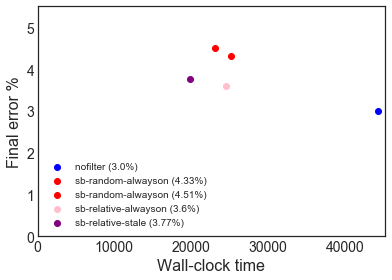

kath-biased_cifar100_wideresnet_0_128_384_0.0005_trial1_seed1337_v5
kath-biased_cifar100_wideresnet_0_128_384_0.0005_trial1_seed1337_v5
kath-biased_cifar100_wideresnet_0_128_512_0.0005_trial1_seed1337_v5
kath-biased_cifar100_wideresnet_0_128_512_0.0005_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_512_3_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_512_3_trial1_seed1337_v5
nofilter_cifar100_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
nofilter_cifar100_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_3_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-stale_cifar100_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-stale_cifar100_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
../plots/19083

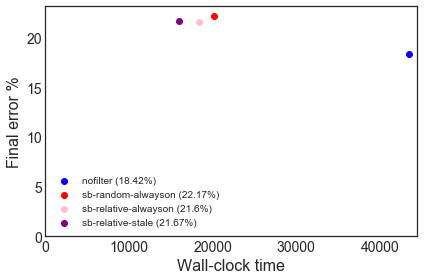

kath-biased_svhn_wideresnet_0_128_384_0.0005_trial1_seed1337_v5
kath-biased_svhn_wideresnet_0_128_384_0.0005_trial1_seed1337_v5
kath-biased_svhn_wideresnet_0_128_512_0.0005_trial1_seed1337_v5
kath-biased_svhn_wideresnet_0_128_512_0.0005_trial1_seed1337_v5
nofilter_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
nofilter_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-stale_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
sb-relative-stale_svhn_wideresnet_0_128_1024_0.0005_trial1_seed1337_v5
../plots/190830_lr1//pareto-svhn.pdf


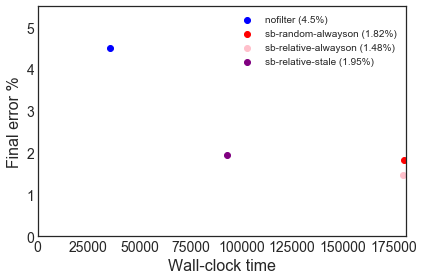

<Figure size 432x288 with 0 Axes>

In [295]:
# LR 1
pareto = True
sweeps = False

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/190830_lr1/cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

if sweeps:
    experiment_names = ["190830_lr1"]
    if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                         strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale",
                                     "nofilter",
                                     "kath-reweighted"
                                    ])

    experiment_dir = "../data/output/cifar100/"
    plot_dir = "{}/190830_lr1/cifar100/".format(plot_home_dir)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    experiment_names = ["190830_lr1", "190901_kathtest_unbiased"]
    if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                         strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale",
                                     #"sampling-random",
                                     "nofilter",
                                     "kath-reweighted"
                                ])

    experiment_dir = "../data/output/svhn/"
    plot_dir = "{}/190830_lr1/svhn/".format(plot_home_dir)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    experiment_names = ["190825_soa",
                        "190830_lr1"
                       ]
    if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                         strategies=[#"sb-relative-stale",
                                     "sb-relative-alwayson",
                                     "nofilter",
                                     "kath-reweighted"
                                    ])
if pareto:
    datasets = ["cifar10", "cifar100", "svhn"]
    for dataset in datasets:
        experiment_dir = "../data/output/{}".format(dataset)
        plot_dir = "{}/190830_lr1/".format(plot_home_dir)
        experiment_names = ["190830_lr1"]
        plot_pareto(experiment_names, experiment_dir, plot_dir, dataset, trials=[1],
                    strategies=["sb-relative-stale",
                                "sb-relative-alwayson",
                                "nofilter",
                                "sb-random-alwayson",
                                #"kath-reweighted"
                                ])

('../data/output/cifar10/', '190830_beta')
kath-reweighted_cifar10_wideresnet_0_128_256_1_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_256_1_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_384_2_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_384_2_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_640_4_trial1_seed1337_v5
kath-reweighted_cifar10_wideresnet_0_128_640_4_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-random-alwayson_cifar10_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-relative-alwayson_cifar10_wideresnet_0_128_1024_1_trial1_seed1337_

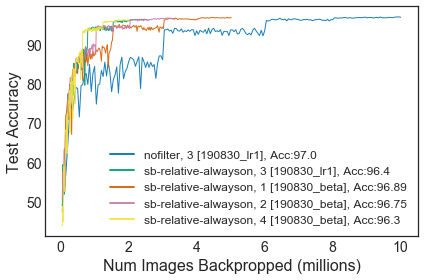

../plots/190830_beta/cifar10//Num-Images-Backpropped-(millions)_Test-Error.pdf


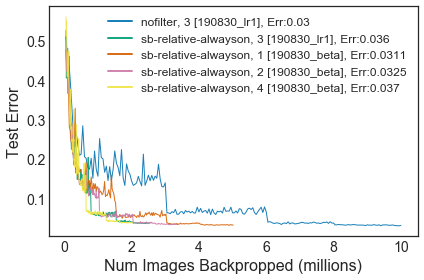

../plots/190830_beta/cifar10//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


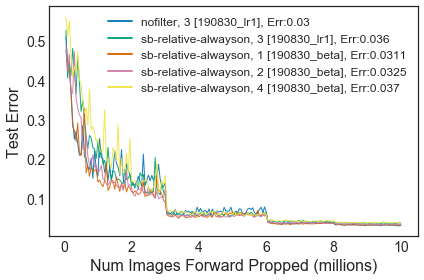

../plots/190830_beta/cifar10//Seconds-elapsed_Test-Error.pdf


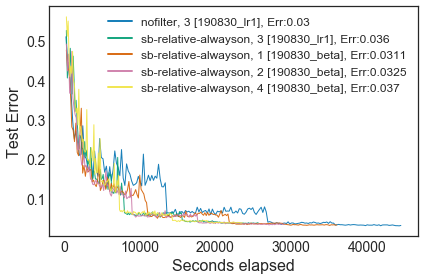

../plots/190830_beta/cifar10//Num-Images-Backpropped-(millions)_Test-Loss.pdf


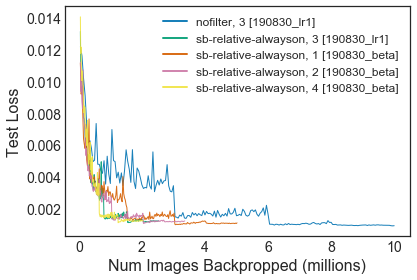

('../data/output/cifar100/', '190830_beta')
kath-reweighted_cifar100_wideresnet_0_128_256_1_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_256_1_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_384_2_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_384_2_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_640_4_trial1_seed1337_v5
kath-reweighted_cifar100_wideresnet_0_128_640_4_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-random-alwayson_cifar100_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-relative-alwayson_cifar100_wideresnet_0_128_1024_1_t

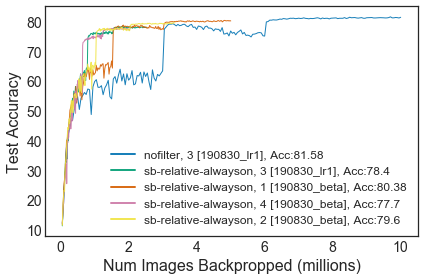

../plots/190830_beta/cifar100//Num-Images-Backpropped-(millions)_Test-Error.pdf


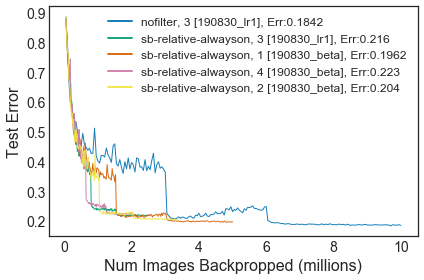

../plots/190830_beta/cifar100//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


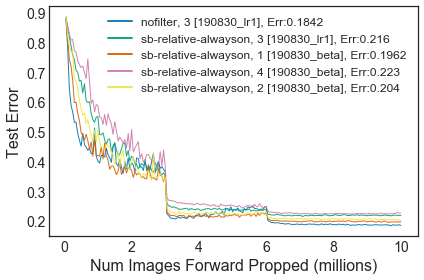

../plots/190830_beta/cifar100//Seconds-elapsed_Test-Error.pdf


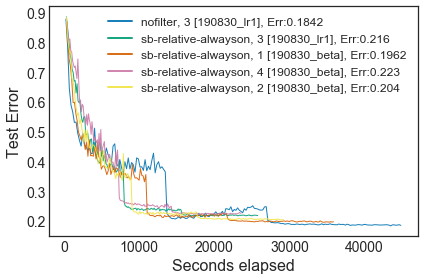

../plots/190830_beta/cifar100//Num-Images-Backpropped-(millions)_Test-Loss.pdf


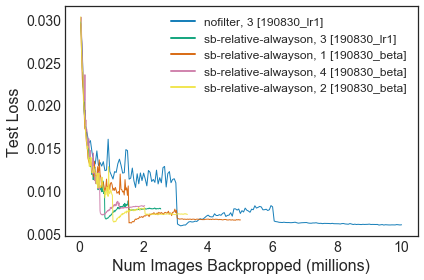

('../data/output/svhn/', '190830_beta')
sb-random-alwayson_svhn_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-random-alwayson_svhn_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_2_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-relative-alwayson_svhn_wideresnet_0_128_1024_4_trial1_seed1337_v5
sb-relative-stale_svhn_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-relative-stale_svhn_wideresnet_0_128_1024_1_trial1_seed1337_v5
sb-relative-

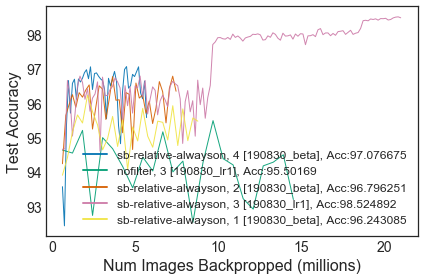

../plots/190830_beta/svhn//Num-Images-Backpropped-(millions)_Test-Error.pdf


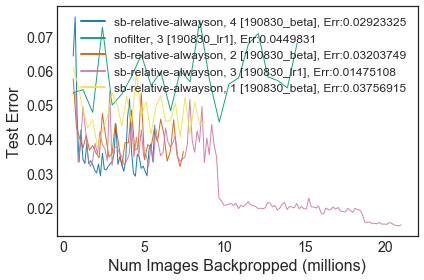

../plots/190830_beta/svhn//Num-Images-Forward-Propped-(millions)_Test-Error.pdf


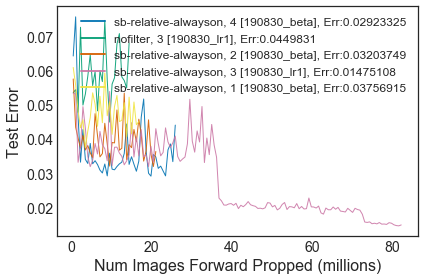

../plots/190830_beta/svhn//Seconds-elapsed_Test-Error.pdf


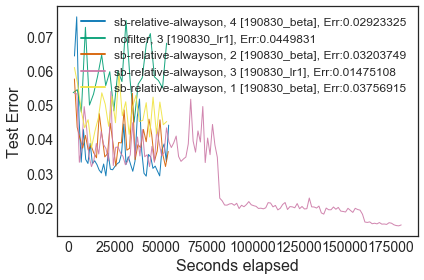

../plots/190830_beta/svhn//Num-Images-Backpropped-(millions)_Test-Loss.pdf


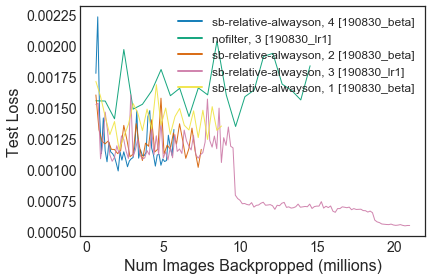

<Figure size 432x288 with 0 Axes>

In [298]:
# Sweep of SB's selectivity
pareto = False
sweeps = True

experiment_dir = "../data/output/cifar10/"
plot_dir = "{}/190830_beta/cifar10/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

if sweeps:
    experiment_names = ["190830_beta", "190830_lr1"]
    if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                         strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale",
                                     #"sampling-random",
                                     "nofilter",
                                     #"kath-reweighted"
                                    ])

    experiment_dir = "../data/output/cifar100/"
    plot_dir = "{}/190830_beta/cifar100/".format(plot_home_dir)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    experiment_names = ["190830_beta", "190830_lr1"]
    if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                         strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale",
                                     #"sampling-random",
                                     "nofilter",
                                     #"kath-reweighted"
                                ])
        
    experiment_dir = "../data/output/svhn/"
    plot_dir = "{}/190830_beta/svhn/".format(plot_home_dir)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    experiment_names = ["190830_beta", "190830_lr1"]
    if True:
        plot_experiments(experiment_names, experiment_dir, plot_dir, trials=[1],
                         strategies=["sb-relative-alwayson",
                                     #"sb-relative-stale",
                                     #"sampling-random",
                                     "nofilter",
                                     #"kath-reweighted"
                                ])
        
if pareto:
    datasets = ["cifar10", "cifar100", "svhn"]
    for dataset in datasets:
        experiment_dir = "../data/output/{}".format(dataset)
        plot_dir = "{}/190830_beta/".format(plot_home_dir)
        experiment_names = ["190830_beta", "190830_lr1"]
        plot_pareto(experiment_names, experiment_dir, plot_dir, dataset, trials=[1],
                    strategies=["sb-relative-stale",
                                "sb-relative-alwayson",
                                "nofilter",
                                "sb-random-alwayson",
                                #"kath-reweighted"
                                ])